#Họ tên SV
Nguyễn Hoàng Thông - 52000861

Nguyễn Quang Huy - 520000057

Cao Hoàng Oanh - 52100917



# Bài 2: (7 điểm): làm chung trong nhóm
Đưa ra một bài toán dự đoán có thể giải quyết bằng học máy (machine leanring) với các yêu cầu sau:
-	Số Feature/Attribute gồm nhiều kiểu: categorial và numerical;
-	Dữ liệu phải chưa được học, thực tập trên lớp và trong bài tập về nhà;

1)	Phân tích thống kê trên dữ liệu, vẽ các đồ thị để hiểu bài toán, hiểu dữ liệu. Tìm hiểu các đặc trưng và đánh gía vai trò của các đặc trưng đối với mục tiêu bài toán;
2)	Ứng dụng các mô hình học máy cơ bản để giải quyết bài toán, bao gồm cả các mô hình thuộc Ensemble Learing;
3)	Sử dụng Feed Forward Neural Network và Reccurent Neural Network (hoặc mô thuộc loại này) để giải quyết bài toán;
4)	Áp dụng các kỹ thuật tránh Overfiting trên các mô hình của câu (2) và câu (3) để giải quyết bài toán;
5)	Sau khi huấn luyện xong mô hình thì muốn cải thiện độ chính xác, ta sẽ làm gì để giải quyết nó? Phân tích các trường hợp sai, đề ra giải pháp và thực hiện nó, sau đó đánh giá xem có cải tiến so với trước không.

* **1 Giới thiệu**
* **2 Nạp và kiểm tra dữ liệu**
    * 2.1 Nạp dữ liệu
    * 2.2 Phát hiện giá trị ngoại lệ
    * 2.3 Kết hợp tập huấn luyện và tập thử nghiệm
    * 2.4 Kiểm tra giá trị null và thiếu sót
* **3 Phân tích đặc trưng**
    * 3.1 Giá trị số
    * 3.2 Giá trị phân loại
* **4 Điền vào giá trị thiếu**
    * 4.1 Tuổi
* **5 Kỹ thuật tạo đặc trưng**
    * 5.1 Tên/Tiêu đề
    * 5.2 Kích thước gia đình
    * 5.3 Cabin
    * 5.4 Vé
* **6 Mô hình hóa**
    * 6.1 Mô hình hóa đơn giản
        * 6.1.1 Mô hình hóa chéo
        * 6.1.2 Tinh chỉnh siêu tham số cho các mô hình tốt nhất
        * 6.1.3 Vẽ đường cong học tập
        * 6.1.4 Độ quan trọng của đặc trưng cho các mô hình dựa trên cây
    * 6.2 Mô hình hóa kết hợp
        * 6.2.1 Kết hợp các mô hình
    * 6.3 Dự đoán
        * 6.3.1 Dự đoán và Đệ trình kết quả

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Nạp và kiểm tra dữ liệu
### 2.1 Nạp dữ liệu

In [ ]:
# Load data
##### Load train and Test set

train = pd.read_csv('/content/drive/My Drive/52000861_52000057_52100917/train.csv')
test = pd.read_csv('/content/drive/My Drive/52000861_52000057_52100917/test.csv')
IDtest = test["PassengerId"]

### 2.2 Phát hiện giá trị ngoại lệ

In [ ]:
# Outlier detection

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

Vì các ngoại lệ có thể có tác động đáng kể đến dự đoán (đặc biệt đối với các vấn đề hồi quy), tôi đã chọn quản lý chúng.

Tôi đã sử dụng phương pháp Tukey (Tukey JW., 1977) để phát hiện các thông số xác định phạm vi liên vùng bao gồm giữa tứ phân vị thứ 1 và thứ 3 của các giá trị phân phối (IQR). Ngoại lệ là một hàng có giá trị đặc trưng nằm ngoài (IQR +- bước ngoại lệ).


Tôi quyết định phát hiện các ngoại lệ từ các đặc điểm giá trị số (Tuổi, SibSp, Sarch và Fare). Sau đó, tôi coi các ngoại lệ là các hàng có ít nhất hai giá trị số ngoại lệ.

In [ ]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


Chúng tôi phát hiện 10 ngoại lệ. Hành khách 28, 89 và 342 có giá vé cao

7 mẫu còn lại có giá trị SibSP rất cao.

In [ ]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 Kết hợp tập huấn luyện và tập thử nghiệm

In [ ]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

Tôi tham gia đào tạo và kiểm tra các tập dữ liệu để có được cùng số lượng tính năng trong quá trình chuyển đổi phân loại (Xem kỹ thuật tính năng).

### 2.4 Kiểm tra giá trị null và thiếu sót

In [ ]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Các tính năng Tuổi và Cabin có một phần quan trọng là các giá trị bị thiếu.

**Các giá trị còn thiếu còn sót lại tương ứng với tập dữ liệu thử nghiệm tham gia (Cột còn lại không tồn tại trong bộ thử nghiệm và đã được thay thế bằng các giá trị NaN khi nối tập huấn luyện và bộ thử nghiệm)**

In [ ]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Phân tích đặc trưng
### 3.1 Giá trị số

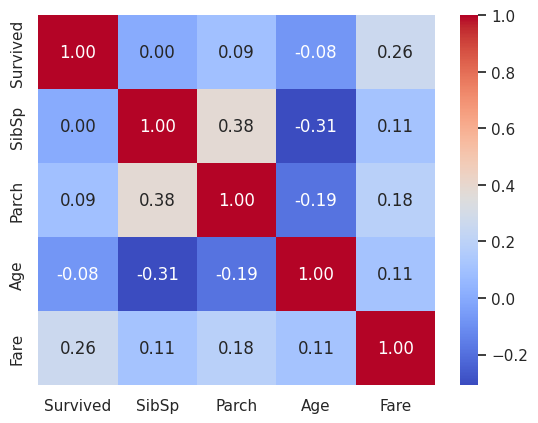

In [ ]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Chỉ có tính năng Giá vé dường như có mối tương quan đáng kể với xác suất sống sót.

Điều đó không có nghĩa là các tính năng khác không hữu ích. Các quần thể phụ trong các đặc điểm này có thể tương quan với khả năng sống sót. Để xác định điều này, chúng ta cần khám phá chi tiết các tính năng này

#### SibSP

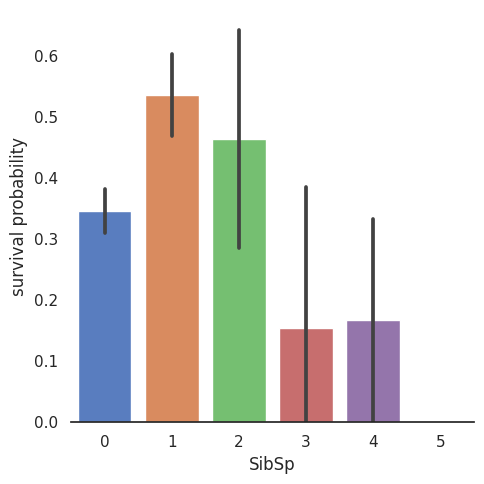

In [ ]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", palette="muted")

g.despine(left=True)
g = g.set_ylabels("survival probability")

Có vẻ như hành khách có nhiều anh chị em/vợ chồng sẽ ít có cơ hội sống sót

Hành khách đơn lẻ (0 SibSP) hoặc cùng với hai người khác (SibSP 1 hoặc 2) có nhiều cơ hội sống sót hơn

Quan sát này khá thú vị, chúng ta có thể xem xét một tính năng mới mô tả các danh mục này (Xem kỹ thuật tính năng)

#### Parch

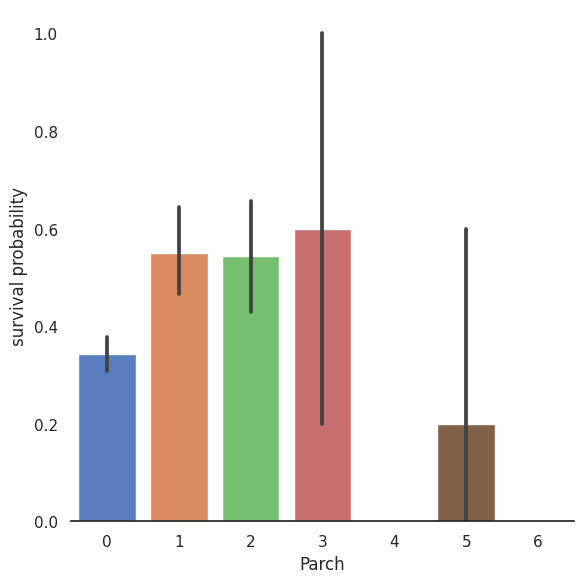

In [ ]:
# Explore Parch feature vs Survived
g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height=6, palette="muted")


g.despine(left=True)
g = g.set_ylabels("survival probability")

Những gia đình nhỏ có nhiều cơ hội sống sót hơn so với những gia đình độc thân (Parch 0), trung bình (Parch 3,4) và các gia đình lớn (Parch 5,6 ).

Hãy cẩn thận vì có độ lệch chuẩn quan trọng về khả năng sống sót của hành khách đi cùng 3 cha mẹ/trẻ em

#### Age

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


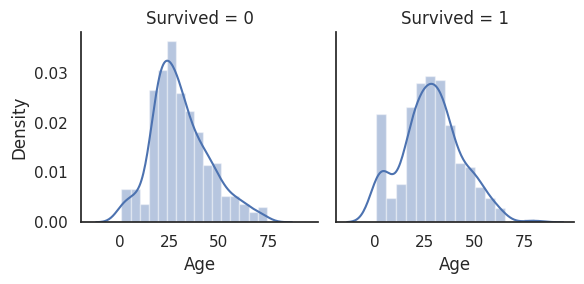

In [ ]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")



Phân phối tuổi dường như là phân phối đuôi, có thể là phân phối gaussian.

Chúng tôi nhận thấy rằng sự phân bổ độ tuổi không giống nhau ở các quần thể sống sót và không sống sót. Thật vậy, có một đỉnh tương ứng với những hành khách trẻ tuổi sống sót. Chúng tôi cũng thấy rằng những hành khách trong độ tuổi từ 60-80 có ít khả năng sống sót hơn.

Vì vậy, ngay cả khi "Tuổi" không tương quan với "Sống sót", chúng ta có thể thấy rằng có nhiều loại hành khách ở độ tuổi ít nhiều có cơ hội sống sót.

Có vẻ như những hành khách còn rất trẻ có nhiều cơ hội sống sót hơn.

<ipython-input-17-60c53fc48d52>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
<ipython-input-17-60c53fc48d52>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)


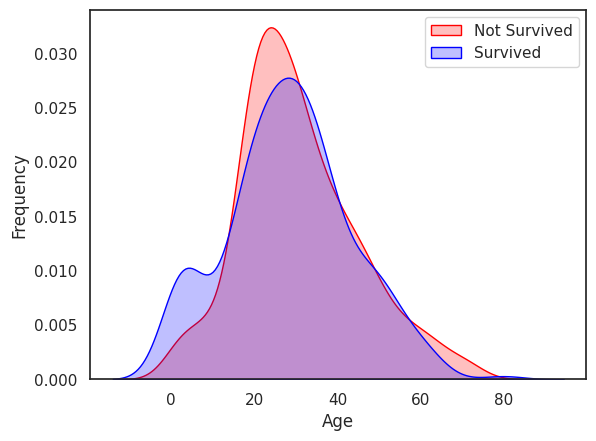

In [ ]:
# Explore Age distibution
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

Khi chúng ta áp dụng hai mật độ chồng lên nhau, chúng ta thấy rõ một đỉnh tương ứng (từ 0 đến 5) đối với trẻ sơ sinh và trẻ nhỏ.

#### Fare

In [ ]:
dataset["Fare"].isnull().sum()

1

In [ ]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

Vì chúng tôi thiếu một giá trị nên tôi quyết định điền vào đó giá trị trung bình, giá trị này sẽ không có ảnh hưởng quan trọng đến dự đoán.

<ipython-input-20-2b85b20d935d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))


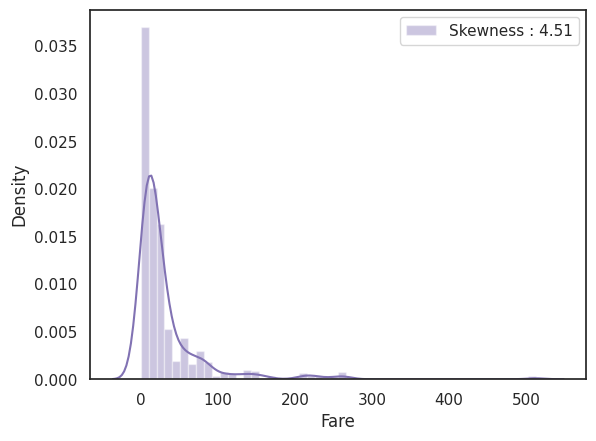

In [ ]:
# Explore Fare distribution
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

Như chúng ta có thể thấy, việc phân phối giá vé rất sai lệch. Điều này có thể dẫn đến các giá trị quá tải rất cao trong mô hình, ngay cả khi nó được chia tỷ lệ.

Trong trường hợp này, tốt hơn là chuyển đổi nó bằng hàm log để giảm độ lệch này.

In [ ]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

<ipython-input-22-35ec8efd2ddc>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))


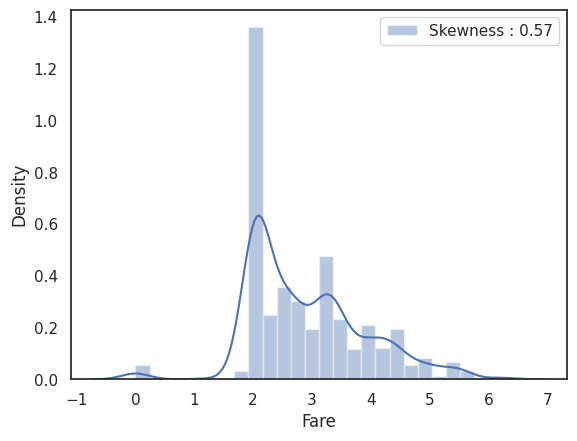

In [ ]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

Độ lệch giảm rõ rệt sau khi chuyển đổi nhật ký

### 3.2 Giá trị phân loại
Sex

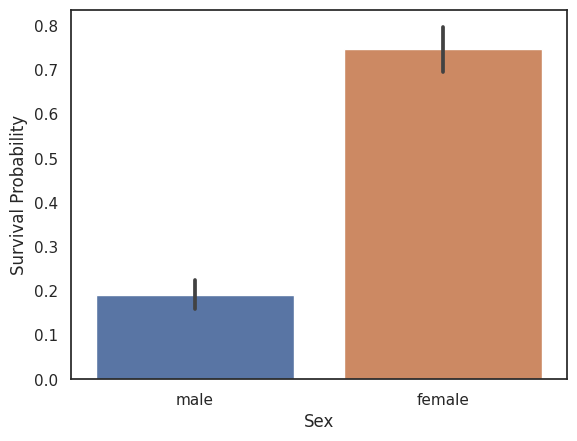

In [ ]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [ ]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


Rõ ràng là Nam có ít cơ hội sống sót hơn Nữ.

Vì vậy, Giới tính có thể đóng một vai trò quan trọng trong việc dự đoán khả năng sống sót.

Với những ai đã xem phim Titanic (1997), tôi tin chắc rằng, tất cả chúng ta đều nhớ đến câu nói này trong quá trình sơ tán: “Phụ nữ và trẻ em là trên hết”.

#### Pclass

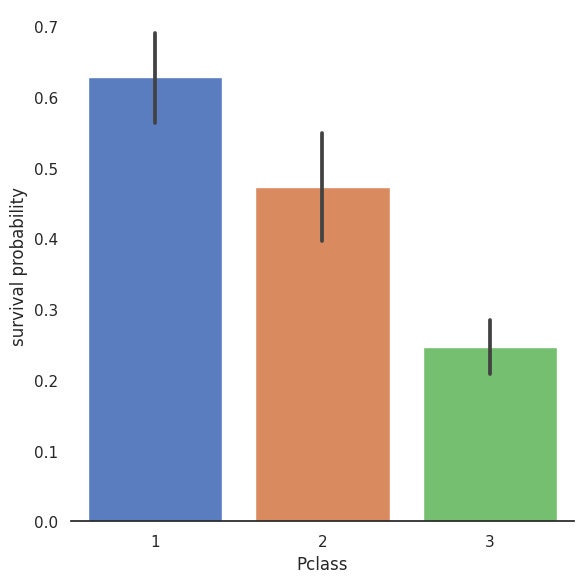

In [ ]:
# Explore Pclass vs Survived
g = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")


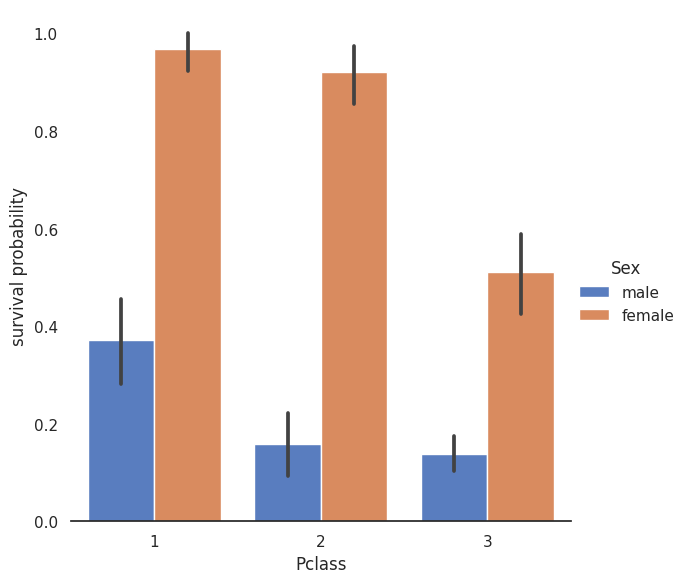

In [ ]:
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")


Tỷ lệ sống sót của hành khách ở 3 hạng không giống nhau. Hành khách hạng nhất có nhiều cơ hội sống sót hơn hành khách hạng hai và hạng ba.

Xu hướng này được bảo tồn khi chúng ta xem xét cả hành khách nam và nữ.

#### Embarked

In [ ]:
dataset["Embarked"].isnull().sum()

2

In [ ]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

Vì chúng tôi thiếu hai giá trị nên tôi quyết định điền vào chúng giá trị thường xuyên nhất là "Embarked" (S).

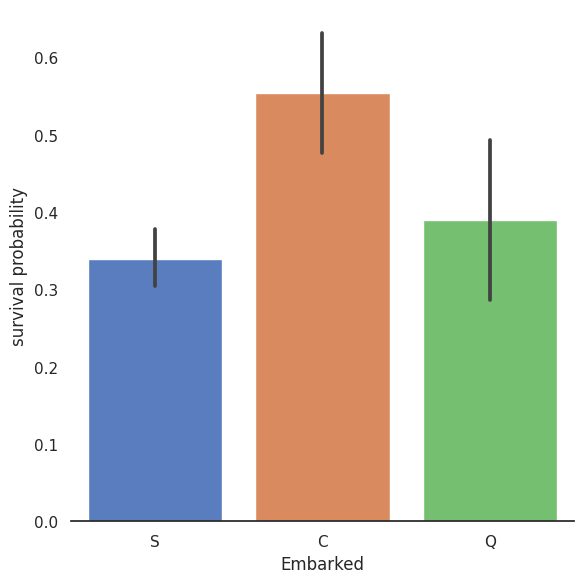

In [ ]:
g = sns.catplot(x="Embarked", y="Survived", data=train,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")


Có vẻ như hành khách đến từ Cherbourg (C) có nhiều cơ hội sống sót hơn.

Giả thuyết của tôi là tỷ lệ hành khách hạng nhất đến từ Cherbourg cao hơn Queenstown (Q), Southampton (S).

Hãy xem phân phối Pclass vs Embarked

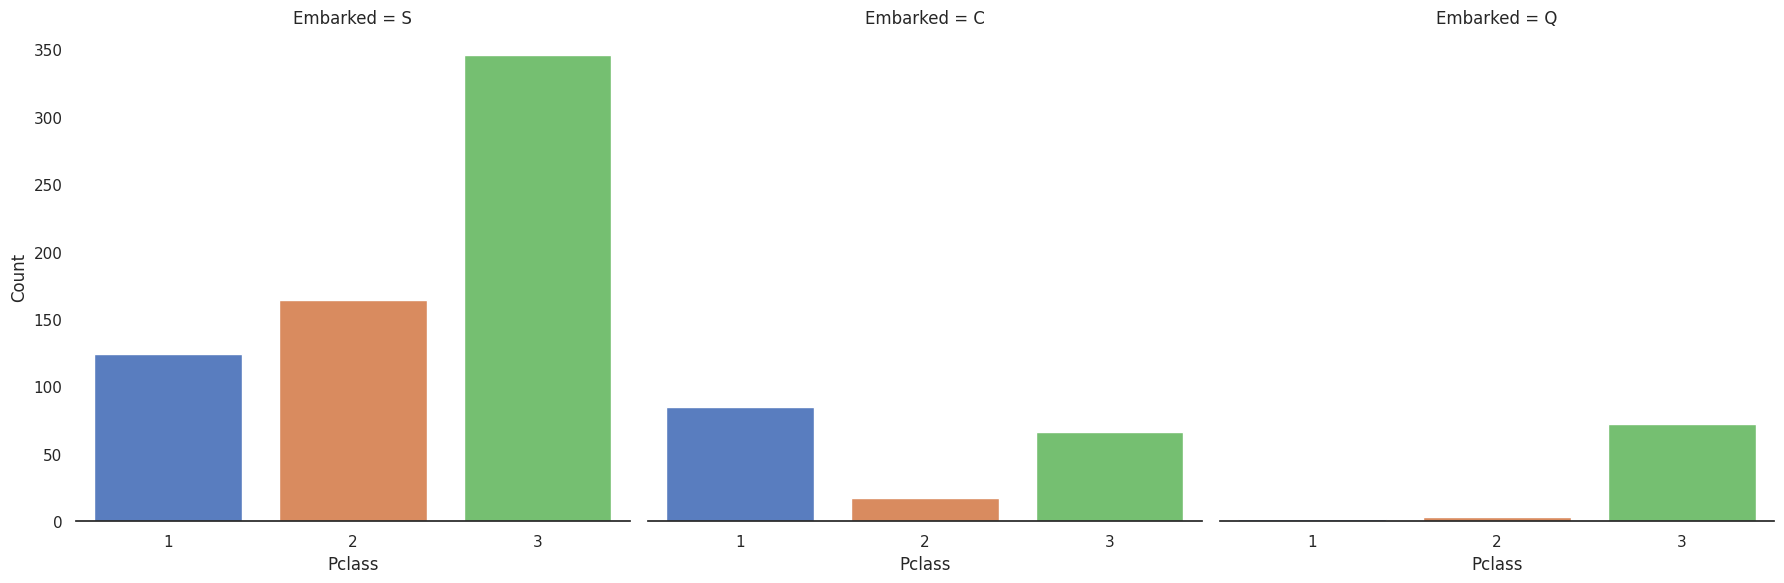

In [ ]:
g = sns.catplot(data=train, x="Pclass", col="Embarked", height=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

Thật vậy, hạng ba là hạng thường xuyên nhất dành cho hành khách đến từ Southampton (S) và Queenstown (Q), trong khi hành khách ở Cherbourg chủ yếu ở hạng nhất có tỷ lệ sống sót cao nhất.

Tại thời điểm này, tôi không thể giải thích tại sao hạng nhất lại có tỷ lệ sống sót cao hơn. Giả thuyết của tôi là hành khách hạng nhất được ưu tiên trong quá trình sơ tán do ảnh hưởng của họ.

## 4. Điền vào giá trị thiếu
### 4.1 Age

Như chúng ta thấy, cột Tuổi chứa 256 giá trị bị thiếu trong toàn bộ tập dữ liệu.

Vì có những nhóm dân cư có nhiều cơ hội sống sót hơn (ví dụ như trẻ em), nên giữ đặc điểm tuổi và quy các giá trị còn thiếu.

Để giải quyết vấn đề này, tôi đã xem xét các tính năng tương quan nhất với Tuổi (Giới tính, Parch, Pclass và SibSP).

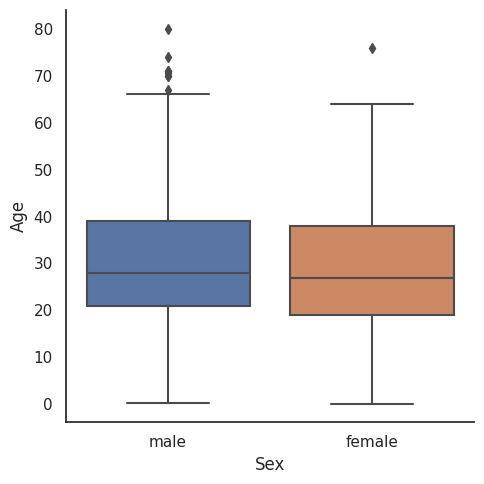

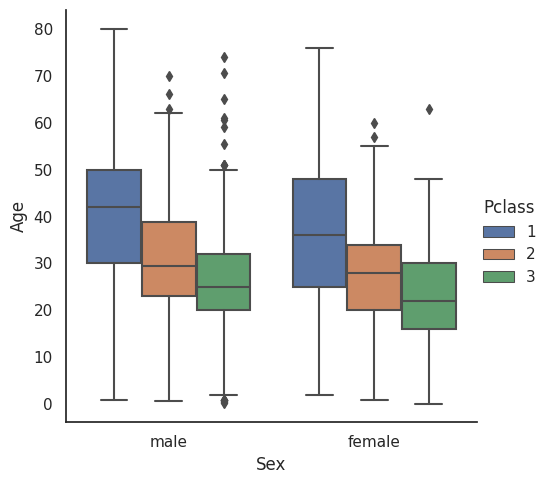

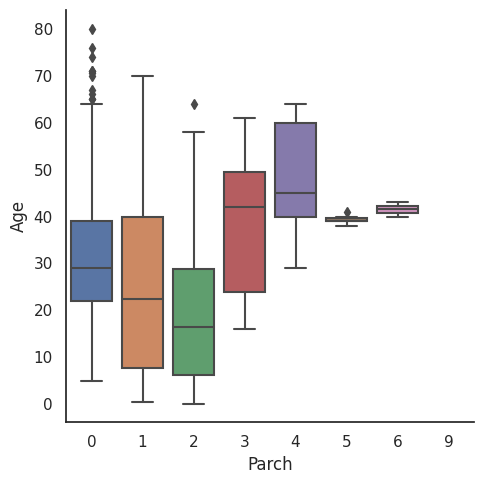

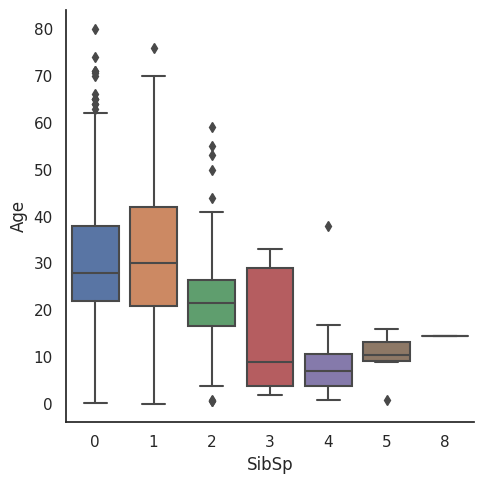

In [ ]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

Sự phân bổ độ tuổi dường như giống nhau ở các quần thể Nam và Nữ, vì vậy Giới tính không có nhiều thông tin để dự đoán Tuổi.

Tuy nhiên, hành khách hạng 1 lớn tuổi hơn hành khách hạng 2 và hành khách hạng 3 cũng lớn tuổi hơn.

Hơn nữa, hành khách càng có nhiều cha mẹ/con cái thì càng lớn tuổi và hành khách càng có anh chị em/vợ chồng thì càng trẻ.

In [ ]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

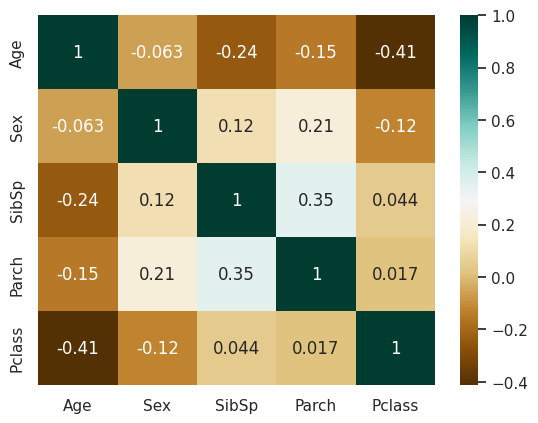

In [ ]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

Bản đồ tương quan xác nhận các quan sát của catplot ngoại trừ Parch. Tuổi tác không tương quan với Giới tính nhưng lại tương quan nghịch với Pclass, Parch và SibSp.

Trong cốt truyện Age do Parch đóng vai, Age ngày càng tăng theo số lượng cha mẹ / con cái. Nhưng mối tương quan chung là tiêu cực.

Vì vậy, tôi quyết định sử dụng SibSP, Parch và Pclass để tính tuổi còn thiếu.

Chiến lược này là lấp đầy Tuổi bằng độ tuổi trung bình của các hàng tương tự theo Pclass, Parch và SibSp.

In [ ]:
# Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med



<ipython-input-34-fbaf21940890>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-34-fbaf21940890>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-34-fbaf21940890>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-34-fbaf21940890>:11: SettingWithCopyWarning: 
A value is trying to be set on

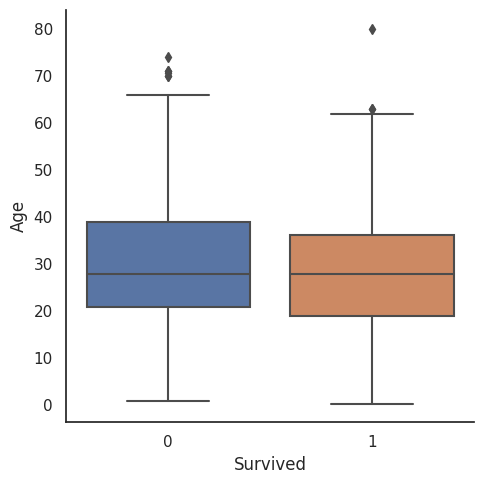

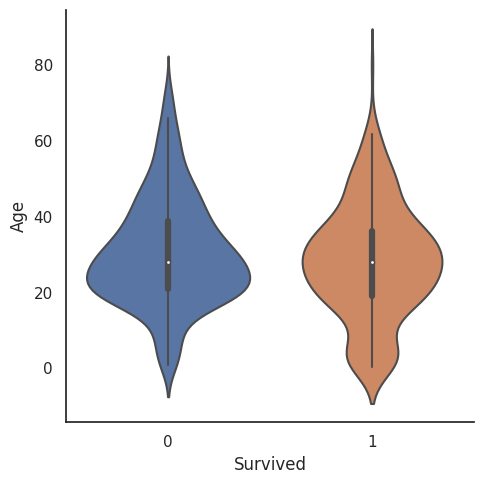

In [ ]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

Không có sự khác biệt giữa giá trị trung bình của tuổi ở tiểu quần thể sống sót và không sống sót.

Nhưng trong âm mưu vĩ cầm của những hành khách sống sót, chúng tôi vẫn nhận thấy rằng những hành khách rất trẻ có tỷ lệ sống sót cao hơn.

## 5. Kỹ thuật tạo đặc trưng
### 5.1 Name/Title

In [ ]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Đặc trưng Tên chứa thông tin về chức danh của hành khách.

Vì một số hành khách có chức danh nổi bật có thể được ưu tiên hơn trong quá trình sơ tán nên việc thêm họ vào mô hình là một điều thú vị.

In [ ]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

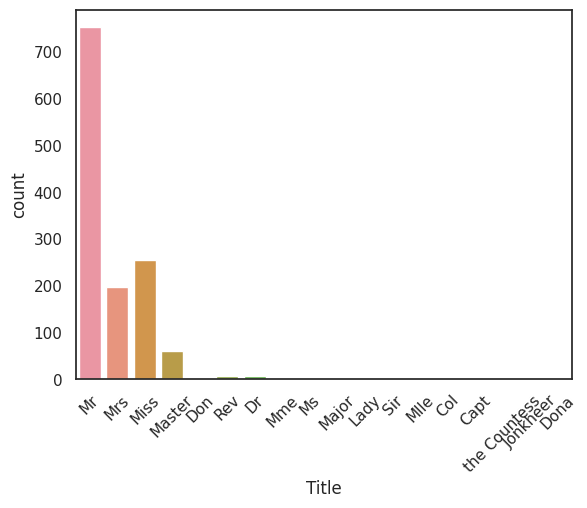

In [ ]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

Có 17 tựa sách trong tập dữ liệu, hầu hết chúng đều rất hiếm và chúng ta có thể nhóm chúng thành 4 loại.

In [ ]:
# Convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

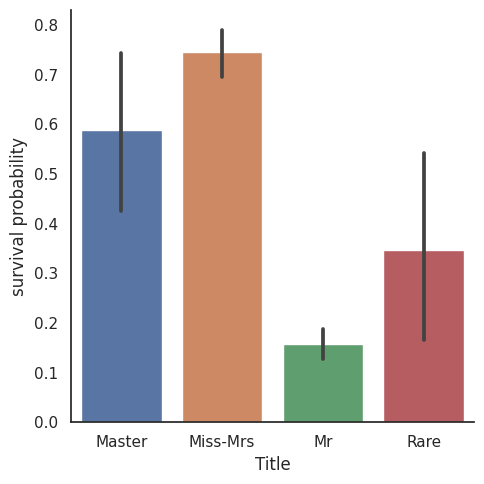

In [ ]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

"Phụ nữ và trẻ em là trên hết"

Điều thú vị cần lưu ý là những hành khách có danh hiệu hiếm có nhiều cơ hội sống sót hơn.

In [ ]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

### 5.2 Quy mô gia đình

Chúng ta có thể tưởng tượng rằng những gia đình đông con sẽ gặp nhiều khó khăn hơn khi sơ tán, tìm kiếm anh chị em/cha mẹ trong quá trình sơ tán. Vì vậy, tôi đã chọn tạo tính năng "Fize" (quy mô gia đình) là tổng của SibSp , Parch và 1 (bao gồm cả hành khách).

In [ ]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

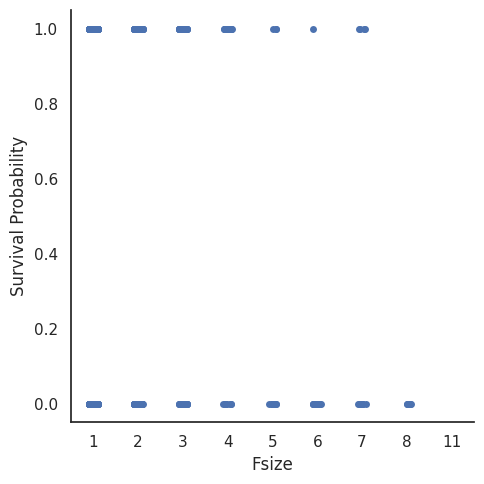

In [ ]:
g = sns.catplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

Quy mô gia đình dường như đóng một vai trò quan trọng, khả năng sống sót là tồi tệ nhất đối với các gia đình lớn.

Ngoài ra, tôi quyết định tạo 4 loại quy mô gia đình.

In [ ]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

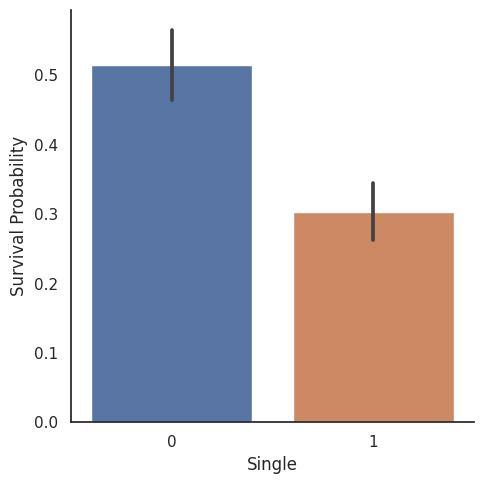

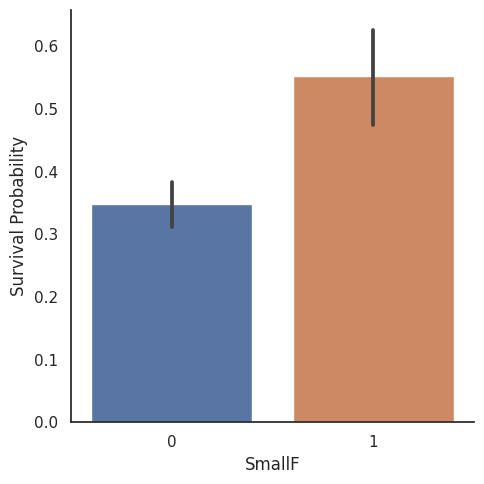

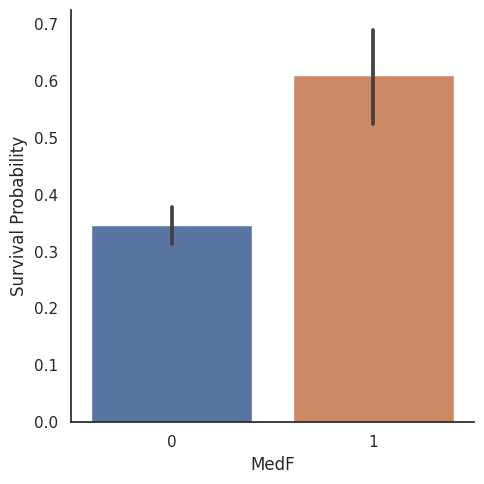

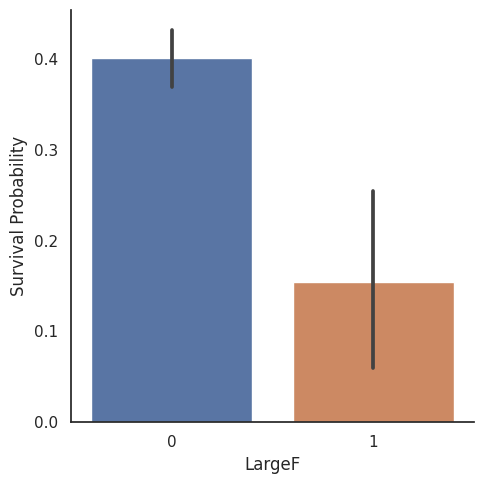

In [ ]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

Biểu đồ phân loại quy mô gia đình cho thấy các gia đình vừa và nhỏ có nhiều cơ hội sống sót hơn so với các gia đình chỉ có một hành khách và các gia đình đông người.

In [ ]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


Ở giai đoạn này, chúng tôi có 22 đặc trưng

### 5.3 Cabin

In [ ]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [ ]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [ ]:
dataset["Cabin"].isnull().sum()

1007

Cột tính năng Cabin chứa 292 giá trị và 1007 giá trị bị thiếu.

Tôi cho rằng hành khách không có cabin sẽ hiển thị giá trị còn thiếu thay vì số cabin.

In [ ]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [ ]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

Chữ cái đầu tiên của cabin biểu thị Bàn làm việc, tôi chọn chỉ giữ thông tin này vì nó cho biết vị trí có thể xảy ra của hành khách trên tàu Titanic.

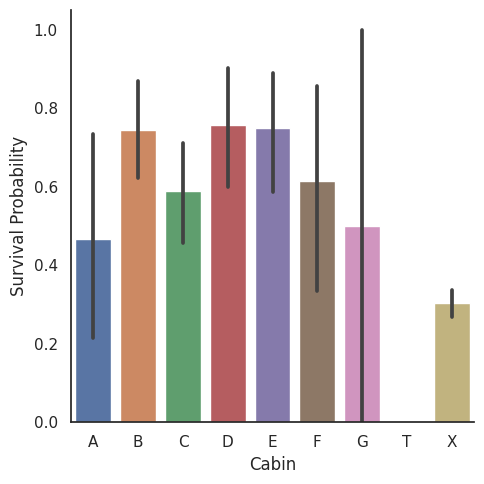

In [ ]:
g = sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")


Do số lượng hành khách có cabin ít nên xác suất sống sót có độ lệch chuẩn quan trọng và chúng tôi không thể phân biệt giữa xác suất sống sót của hành khách ở các bàn khác nhau.

Nhưng chúng ta có thể thấy rằng những hành khách có cabin nhìn chung có nhiều cơ hội sống sót hơn những hành khách không có (X).

Điều này đặc biệt đúng với cabin B, C, D, E và F.

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### 5.4 Ticket

In [ ]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

Điều đó có thể có nghĩa là những vé có cùng tiền tố có thể được đặt cho các cabin đặt cạnh nhau. Do đó, nó có thể dẫn đến việc bố trí các cabin trên tàu trên thực tế.

Vé có cùng tiền tố có thể có hạng và thời gian tồn tại tương tự.

Vì vậy, tôi quyết định thay thế cột tính năng Vé bằng tiền tố vé. Mà có thể có nhiều thông tin hơn.

In [ ]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()


0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [ ]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [ ]:
# Drop useless variables
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [ ]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6. MODELING

In [ ]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

<ipython-input-61-4ded5fa7d752>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"],axis = 1,inplace=True)


In [ ]:
## Separate train features and label

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

<ipython-input-62-be88970b528a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


### 6.1 Mô hình hóa đơn giản
#### 6.1.1 Xác thực chéo các mô hình

Tôi đã so sánh 10 phân loại phổ biến và đánh giá độ chính xác trung bình của từng phân loại bằng quy trình xác thực chéo kfold phân tầng.

* SVC
* Cây quyết định
* AdaBoost
* Rừng ngẫu nhiên
* Cây bổ sung
* Tăng cường độ dốc
* Percepton nhiều lớp (mạng lưới thần kinh)
* KNN
* Hồi quy logistic
* Phân tích phân biệt tuyến tính

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

Text(0.5, 1.0, 'Cross validation scores')

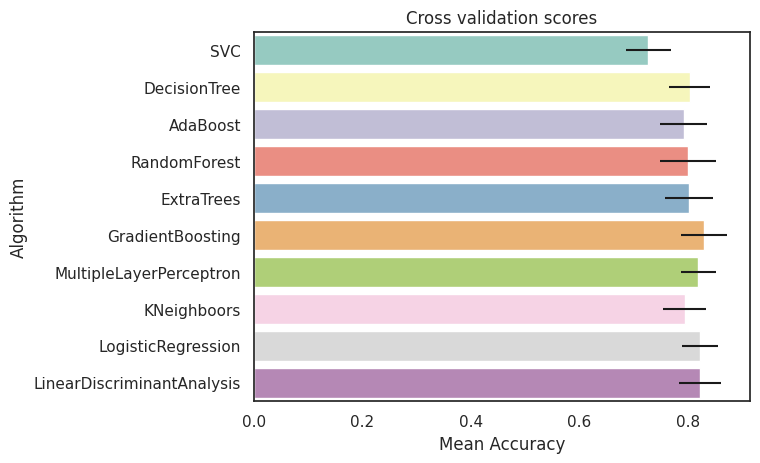

In [ ]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_res, palette="Set3", orient="h", xerr=cv_std)
g.set_xlabel("Mean Accuracy")
g.set_title("Cross validation scores")



Tôi quyết định chọn các bộ phân loại SVC, AdaBoost, RandomForest , ExtraTrees và gradientBoosting cho mô hình tập hợp.

#### 6.1.2 Tinh chỉnh siêu tham số cho các mô hình tốt nhất

Tôi đã thực hiện tối ưu hóa tìm kiếm dạng lưới cho các bộ phân loại AdaBoost, ExtraTrees, RandomForest, gradientBoosting và SVC.

Tôi đặt tham số "n_jobs" thành 4 vì tôi có 4 cpu. Thời gian tính toán giảm đi rõ rệt.

Nhưng hãy cẩn thận, bước này có thể mất nhiều thời gian, tôi mất tổng cộng 15 phút trên 4 cpu.

In [ ]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_


Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


In [ ]:
gsadaDTC.best_score_

0.8275536261491316

In [ ]:
#ExtraTrees
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8297497446373849

In [ ]:
# RFC Parameters tunning
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8297497446373852

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_


Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


0.8320097037793668

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

#### 6.1.3 Vẽ đường cong học tập

Đường cong học tập là một cách hay để thấy tác động quá mức trên tập huấn luyện và ảnh hưởng của kích thước huấn luyện đến độ chính xác.

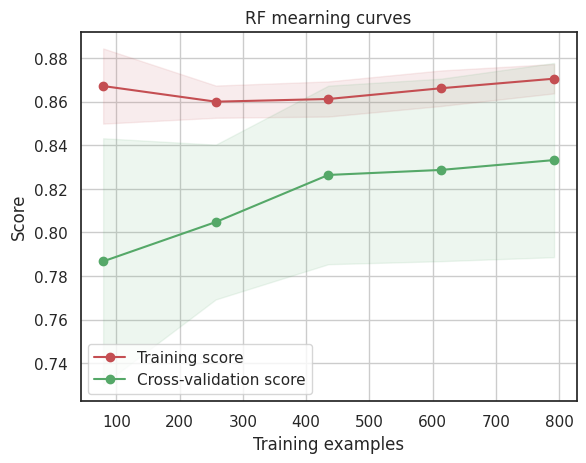

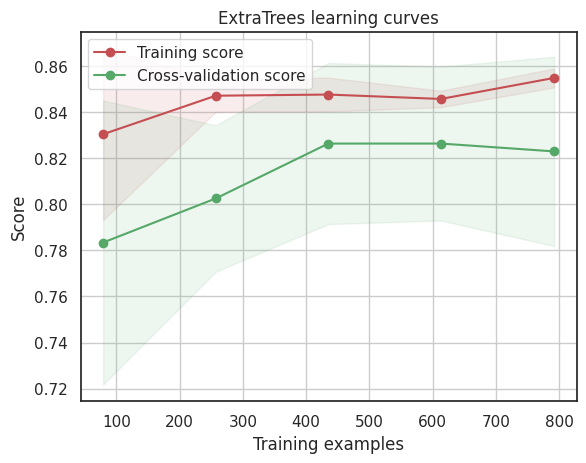

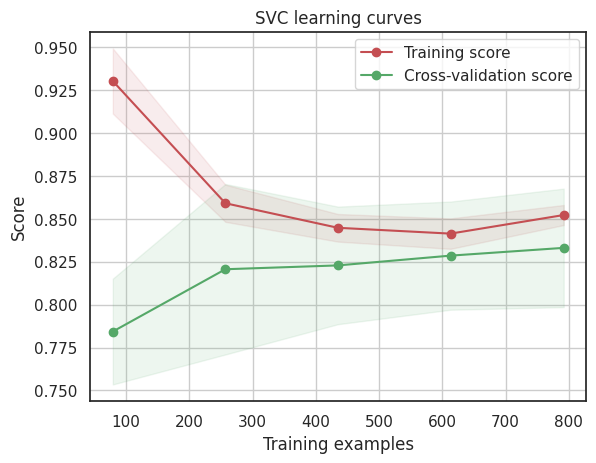

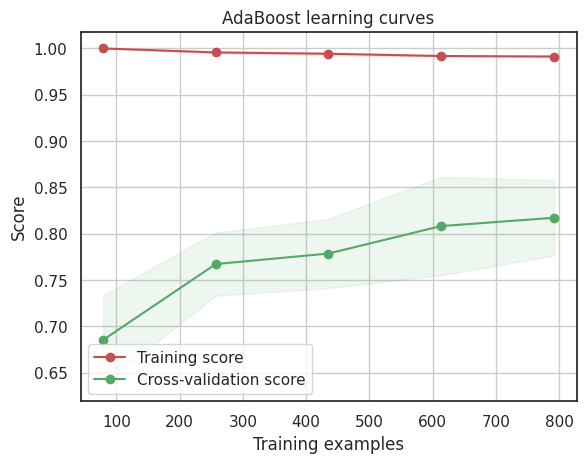

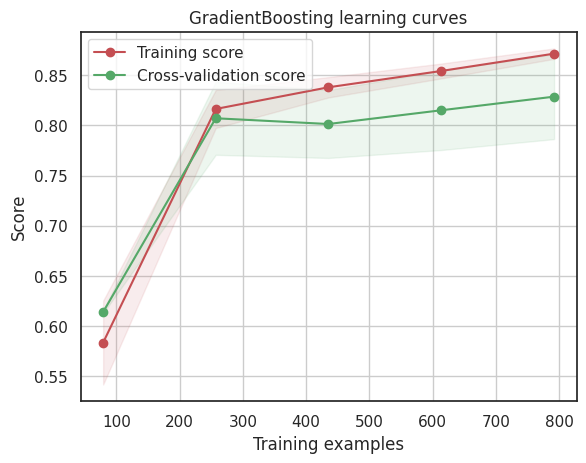

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)



Trình phân loại gradientBoosting và Adaboost có xu hướng phù hợp quá mức với tập huấn luyện. Theo đường cong xác thực chéo ngày càng tăng, gradientBoosting và Adaboost có thể hoạt động tốt hơn với nhiều ví dụ đào tạo hơn.

Các trình phân loại SVC và ExtraTrees dường như khái quát hóa dự đoán tốt hơn vì các đường cong huấn luyện và xác thực chéo gần nhau.

#### 6.1.4 Tầm quan trọng của tính năng phân loại dựa trên cây

Để xem các tính năng hữu ích nhất để dự đoán khả năng sống sót của hành khách, tôi đã hiển thị tầm quan trọng của tính năng đối với 4 phân loại dựa trên cây.

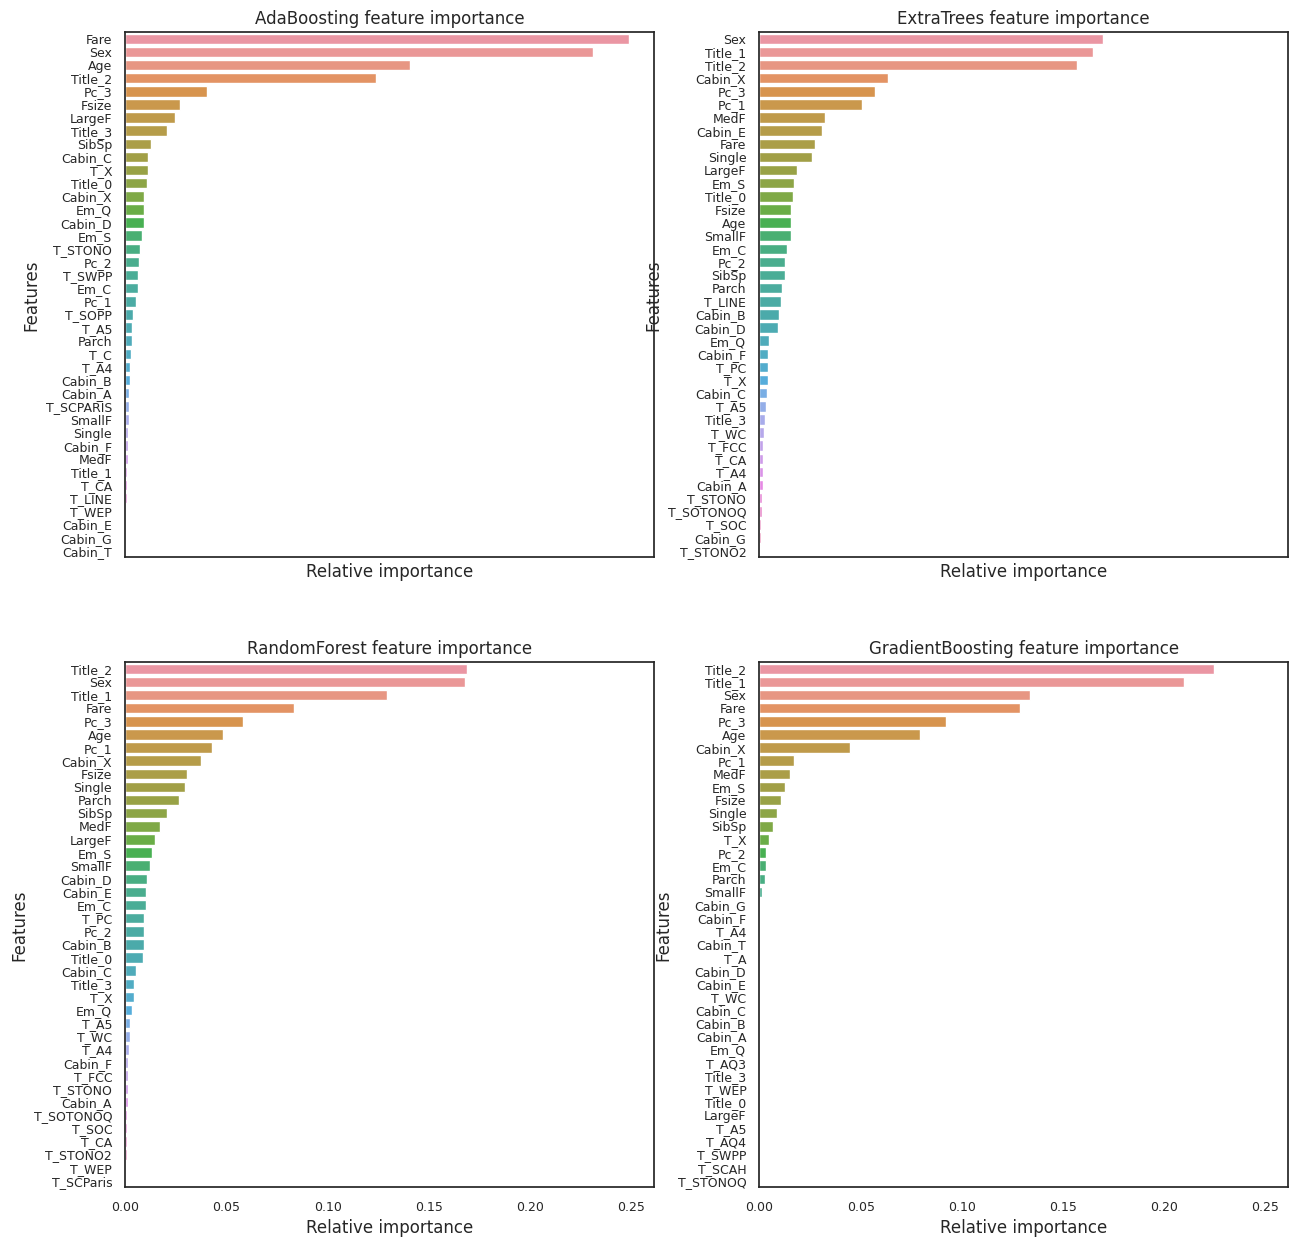

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

Tôi biểu thị tầm quan trọng của tính năng đối với 4 bộ phân loại dựa trên cây (Adaboost, ExtraTrees, RandomForest và gradientBoosting).

Chúng tôi lưu ý rằng bốn phân loại có các tính năng hàng đầu khác nhau tùy theo tầm quan trọng tương đối. Điều đó có nghĩa là những dự đoán của họ không dựa trên những đặc điểm giống nhau. Tuy nhiên, chúng có chung một số đặc điểm quan trọng để phân loại, ví dụ: 'Giá vé', 'Tiêu đề_2', 'Tuổi' và 'Giới tính'.

Tiêu đề_2 cho biết danh mục Bà/Mlle/Mme/Cô/Bà có mối tương quan cao với Giới tính.

Chúng ta có thể nói về điều đó:

- Pc_1, Pc_2, Pc_3 và Fare thể hiện địa vị xã hội chung của hành khách.

- Giới tính và Title_2 (Mrs/Mlle/Mme/Miss/Ms) và Title_3 (Mr) đề cập đến giới tính.

- Tuổi và Tiêu đề_1 (Master) đề cập đến độ tuổi của hành khách.

- Fsize, LargeF, MedF, Single đề cập đến quy mô của nhóm hành khách.

**Theo tầm quan trọng về đặc điểm của 4 phân loại này, dự đoán về khả năng sống sót dường như gắn liền với Độ tuổi, Giới tính, quy mô gia đình và địa vị xã hội của hành khách hơn là vị trí trên thuyền.**

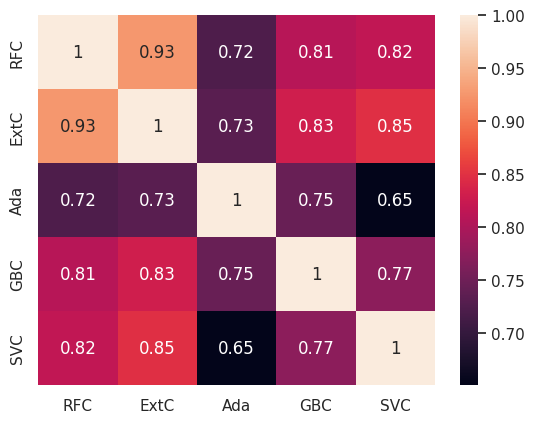

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

Dự đoán có vẻ khá giống nhau đối với 5 bộ phân loại ngoại trừ khi Adaboost được so sánh với các bộ phân loại khác.

5 bộ phân loại đưa ra dự đoán ít nhiều giống nhau nhưng có một số khác biệt. Những khác biệt giữa 5 dự đoán của bộ phân loại là đủ để xem xét một cuộc bỏ phiếu tập thể.

### 6.2 Mô hình hóa tập hợp  Ensemble modeling
#### 6.2.1 Kết hợp mô hình

Tôi đã chọn một bộ phân loại biểu quyết để kết hợp các dự đoán đến từ 5 bộ phân loại.

Tôi muốn chuyển đối số "mềm" cho tham số biểu quyết để tính đến xác suất của mỗi phiếu bầu.

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### 6.3 Dự đoán
#### 6.3.1 Dự đoán và gửi kết quả

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")
results = pd.concat([IDtest, test_Survived], axis=1)
print(results)


     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
